In [80]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Dataset
import joblib
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import re
import gensim.downloader as api
from tqdm import tqdm
import pandas as pd

In [81]:
torch.manual_seed(42)

In [82]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to save the best model.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        # Invert the loss (if you want to maximize something, otherwise use the loss directly)
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

-----

In [83]:
#load the embedding matrix
word2idx = joblib.load('word_to_ids.pkl')
id_to_word = joblib.load('idx_to_word.pkl')

In [84]:
embed_dim = 300
print("Loading Word2Vec model ...")
word2vec_model = api.load("word2vec-google-news-300")  # embed_dim will be 300
print("Loaded Word2Vec model ...")

# Build the embedding matrix.
# For each word in our vocabulary, use the pre-trained embedding if available,
# otherwise initialize randomly.
vocab = list(word2idx.keys())
vocab_size = len(word2idx)
embedding_matrix = np.zeros((vocab_size, embed_dim), dtype=np.float32)

for word, idx in word2idx.items():
    if word in word2vec_model:
        embedding_matrix[idx] = word2vec_model[word]
    else:
        # For PAD token or out-of-vocabulary words, you might set to zeros or random values.
        # Here, we set PAD to zeros and random for others.
        if word == "<pad>":
            embedding_matrix[idx] = np.zeros(embed_dim, dtype=np.float32)
        else:
            embedding_matrix[idx] = np.zeros(embed_dim, dtype=np.float32)
# Convert the numpy matrix to a torch tensor.
embeddings_tensor = torch.tensor(embedding_matrix)

Loading Word2Vec model ...
Loaded Word2Vec model ...


In [54]:
embeddings_tensor.shape

torch.Size([607348, 300])

In [85]:
class DocTower(nn.Module):
    def __init__(self, embed_dim, lstm_hidden_dim, output_dim):
        """
        """
        super(DocTower, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings_tensor, padding_idx=0, freeze=True)
        self.lstm = nn.LSTM(embed_dim, lstm_hidden_dim, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)
    
    def forward(self, x, sequence_lengths):
        x = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(
            x,
            sequence_lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )
        _, (hn, _) = self.lstm(packed)
        last_hidden = hn[-1]  # Shape: (batch_size, lstm_hidden_dim)
        return self.fc(last_hidden)


In [86]:
class TwoTowerModel(nn.Module):
    def __init__(self, output_dim, embed_dim, lstm_hidden_dim_query, lstm_hidden_dim_doc):
        super(TwoTowerModel, self).__init__()
        self.query_tower = DocTower(embed_dim, lstm_hidden_dim_query, output_dim)
        self.doc_tower = DocTower(embed_dim, lstm_hidden_dim_doc, output_dim)
        
    def forward(self, query, doc_positive, doc_negative, query_length, doc_length):
        """
        """
        query_embed = self.query_tower(query, query_length)
        positive_embed = self.doc_tower(doc_positive, doc_length)
        negative_embed = self.doc_tower(doc_negative, doc_length)
        return query_embed, positive_embed, negative_embed


In [87]:
#prepare the data for the query tower work on the query triplets
import json
with open('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/data/train_triples_sample.json') as f:
    data = json.load(f)

with open('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/eda/train_triples_v1.1.json') as f:
    train = json.load(f)

with open('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/eda/valid_triples_v1.1.json') as f:
    val = json.load(f)

In [88]:
average_sentence_length = sum(len(item['query'].split()) for item in data) / len(data)
print(average_sentence_length)#this before stemming and removing stopwords
average_context_length = sum(len(item['positive'].split()) for item in data) / len(data)
print(average_context_length)#this before stemming and removing stopwords

12.0
42.8


In [89]:
print(len(train), len(val))

676193 82360


In [60]:
#data preparartion

In [90]:
SENT_LEN = 12
CONTEXT_LEN = 40

def pad_truncate(data, max_len):
    res = []
    for d in tqdm(data):
        d = d.lower()
        d = re.sub(r'[^a-zA-Z0-9]', ' ', d)
        clean_sent = word_tokenize(d)
        tokens = clean_sent[:max_len]
        tokens += ['<unk>'] * (max_len - len(tokens))
        res.append(tokens)
    return res

#convert to indices
def convert_to_indices(data, word_to_id):
    res = []
    for d in tqdm(data):
        res.append([word_to_id.get(w, word_to_id['<unk>']) for w in d])
    return res


In [91]:
#Wrap in dataset and dataloader

class QueryDataset(Dataset):
    def __init__(self, data, SENT_LEN, CONTEXT_LEN):
        self.queries = [d['query'] for d in data]
        self.positives = [d['positive'] for d in data]
        self.negatives = [d['negative'] for d in data]
        #pad truncates the data
        self.queries = pad_truncate(self.queries, SENT_LEN)
        self.positives = pad_truncate(self.positives, CONTEXT_LEN)
        self.negatives = pad_truncate(self.negatives, CONTEXT_LEN)
        #convert to indices
        self.queries = convert_to_indices(self.queries, word2idx)
        self.positives = convert_to_indices(self.positives, word2idx)
        self.negatives = convert_to_indices(self.negatives, word2idx)
    
    def __len__(self):
        return len(self.queries)
    
    def __getitem__(self, idx):
        return torch.tensor(self.queries[idx], dtype=torch.long), \
                torch.tensor(self.positives[idx], dtype=torch.long), \
                torch.tensor(self.negatives[idx], dtype=torch.long)
    
    def collate_fn(batch):
        queries, positives, negatives = zip(*batch)
        queries = torch.stack(queries)
        positives = torch.stack(positives)
        negatives = torch.stack(negatives)
        queries_lengths = torch.tensor([len(seq) for seq in queries], dtype=torch.int64)
        positives_lengths = torch.tensor([len(seq) for seq in positives], dtype=torch.int64)
        return queries, positives, negatives, queries_lengths, positives_lengths
    
train = train[:200000]
train, val = train_test_split(train, test_size=0.2, random_state=42)
# Wrap in dataset and dataloader
train_dataset = QueryDataset(train, SENT_LEN, CONTEXT_LEN)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=QueryDataset.collate_fn)

val_dataset = QueryDataset(val, SENT_LEN, CONTEXT_LEN)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=QueryDataset.collate_fn)

100%|██████████| 40000/40000 [00:00<00:00, 112311.88it/s]


In [92]:
query_sequence_length = torch.tensor(SENT_LEN, dtype=torch.int64)
doc_sequence_length = torch.tensor(CONTEXT_LEN, dtype=torch.int64)
output_dim = 128
embed_dim = 300
lstm_hidden_dim_query = 128
lstm_hidden_dim_doc = 256
batch_size = 64

# Instantiate the model
model = TwoTowerModel(output_dim, embed_dim, lstm_hidden_dim_query, lstm_hidden_dim_doc)

In [93]:
for query, positive, negative, query_lengths, doc_lengths in val_loader:
    break

In [94]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, query, pos_doc, neg_doc):
        pos_sim = F.cosine_similarity(query, pos_doc)
        neg_sim = F.cosine_similarity(query, neg_doc)
        
        # Compute triplet loss with margin
        loss = torch.clamp(self.margin - pos_sim + neg_sim, min=0.0)
        return loss.mean()

margin = 0.5
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#iterate over batches of the data
train_losses = []
valid_losses = []
epochs = 15
for epoch in range(epochs):
    model.train()
    new_lr = 0.001 * (0.95 ** epoch)  # example: exponentially decay the lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
    for i, (query, positive, negative, query_lengths, doc_lengths) in enumerate(train_loader):
        query_embed, positive_embed, negative_embed = model(query, positive, negative, query_lengths, doc_lengths)
        query_embed = query_embed.float()
        positive_embed = positive_embed.float()
        negative_embed = negative_embed.float()
        optimizer.zero_grad()

        loss = TripletLoss(margin)(query_embed, positive_embed, negative_embed)
        loss.backward()

        # Backward pass
        optimizer.step()
        
        if i % 100 == 0:
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item()}")
    train_loss = loss.item()
    train_losses.append(train_loss)


    # Validation
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  
        for query, positive, negative, query_lengths, doc_lengths in val_loader:
            query_embed, positive_embed, negative_embed = model(query, positive, negative, query_lengths, doc_lengths)
            query_embed = query_embed.float()
            positive_embed = positive_embed.float()
            negative_embed = negative_embed.float()
            loss = TripletLoss(margin)(query_embed, positive_embed, negative_embed)
    valid_loss = loss.item()
    valid_losses.append(valid_loss)
    print(f"====Epoch {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {valid_loss}====")

Epoch 1, Batch 1, Loss: 0.49959123134613037
Epoch 1, Batch 101, Loss: 0.31044310331344604
Epoch 1, Batch 201, Loss: 0.36533868312835693
Epoch 1, Batch 301, Loss: 0.2785533666610718
Epoch 1, Batch 401, Loss: 0.20470072329044342
Epoch 1, Batch 501, Loss: 0.1898835152387619
Epoch 1, Batch 601, Loss: 0.15925388038158417
Epoch 1, Batch 701, Loss: 0.2239697277545929
Epoch 1, Batch 801, Loss: 0.2273484766483307
Epoch 1, Batch 901, Loss: 0.16440537571907043
Epoch 1, Batch 1001, Loss: 0.1773889809846878
Epoch 1, Batch 1101, Loss: 0.20933875441551208
Epoch 1, Batch 1201, Loss: 0.18463020026683807
Epoch 1, Batch 1301, Loss: 0.14595770835876465
Epoch 1, Batch 1401, Loss: 0.1819460242986679
Epoch 1, Batch 1501, Loss: 0.1600143313407898
Epoch 1, Batch 1601, Loss: 0.09947829693555832
Epoch 1, Batch 1701, Loss: 0.127680703997612
Epoch 1, Batch 1801, Loss: 0.19603194296360016
Epoch 1, Batch 1901, Loss: 0.14006519317626953
Epoch 1, Batch 2001, Loss: 0.10511317849159241
Epoch 1, Batch 2101, Loss: 0.15467

In [95]:
#save the model
torch.save(model.state_dict(), './model_twotower2.pth')

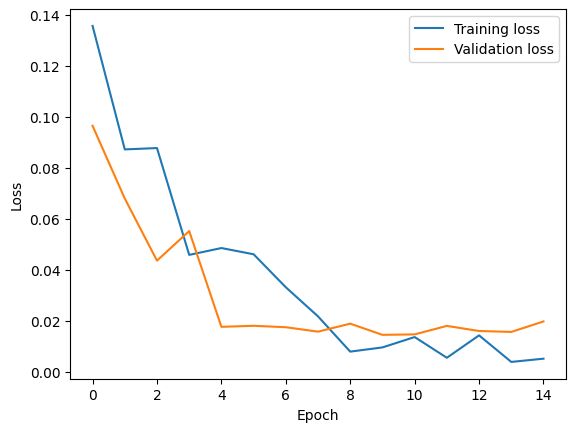

In [96]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

In [97]:
state_dict = torch.load('./model_twotower2.pth', map_location='cpu')
model.load_state_dict(state_dict)

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_64632/308058860.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./model_twotower2.pth

<All keys matched successfully>

In [98]:
#find the most similar search
ind = 2
query_text = val[ind]['query']
documents_text = [i['positive'] for i in val[:64]]
print('query: ', query_text)
print('documents: ')
for t in documents_text:
    print(t)
print('----')
print('the most similar: ', documents_text[ind])

query_text = [query_text]*64
#pad truncates the data
query = pad_truncate(query_text, SENT_LEN)
documents = pad_truncate(documents_text, CONTEXT_LEN)
#convert to indices
query = convert_to_indices(query, word2idx)
documents = convert_to_indices(documents, word2idx)

query = torch.tensor(query, dtype=torch.long)
documents = torch.tensor(documents, dtype=torch.long)


model.eval()  # Set model to evaluation mode
# print(len(query), len(documents), query_lengths, doc_lengths)
print(query.shape, documents.shape)
with torch.no_grad():  
    query_embed, documents_embed, negative_embed = model(query, documents, documents, query_lengths, doc_lengths) 


# Compute cosine similarities
query_embedd = query_embed[0].float().reshape(1,-1)
documents_embed = documents_embed.float()
cos = []
for em in documents_embed:
    cos.append(F.cosine_similarity(query_embedd, em.reshape(1,-1)).item())

query:  what is cointreau made of
documents: 
As you can see, the LEAF is the cost winner in this situation, the Volt and C-Max Energi cost a bit over $100 more, the Prius about $200 more, the Camry $243.33 more, and the Prius PHEV $359.29 more per month than the LEAF. Now let's try an example with a longer commute: 60 miles per day. 
Exclusions. The entire $50,000 you give isn't vulnerable to taxation. The IRS allows exclusions, a dollar limit you can give away tax-free. As of the 2012 tax year, the exclusion amount is $13,000 for each person you make a gift to. If you're married, you can double that: you and your spouse are each entitled to give away $13,000 per person. 
Simple. Grand Marnier is an orange liqueur in the curacao curaçao, tradition And cointreau is a triple. Sec Grand marnier is a blend of cognac and triple, sec so although'it s not a traditional, curacao'curaçao it s a. Similar, product cointreau on the, other hand is straight up a. triple sec Perhaps the two most fam

100%|██████████| 64/64 [00:00<00:00, 491.85it/s]

torch.Size([64, 12]) torch.Size([64, 40])


In [99]:
sorted_pairs = sorted(zip(cos, documents_text), key=lambda pair: pair[0], reverse=True)

# Extract sorted texts (lowest score first)
sorted_texts = [text for _, text in sorted_pairs]
for i in sorted_texts:
    print(i)
    print()

Simple. Grand Marnier is an orange liqueur in the curacao curaçao, tradition And cointreau is a triple. Sec Grand marnier is a blend of cognac and triple, sec so although'it s not a traditional, curacao'curaçao it s a. Similar, product cointreau on the, other hand is straight up a. triple sec Perhaps the two most famous brands of orange liqueur are Grand Marnier and Cointreau, and you might be wondering where they fit in to this taxonomy. Simple. Grand Marnier is an orange liqueur in the curacao curaçao, tradition And cointreau is a triple. sec

Methylsulfonylmethane, which is often abbreviated to MSM, is a sulfurous substance that is found naturally in your body. MSM is sold as nutritional supplements for a variety of health-promoting purposes. As with any nutritional supplement you should talk to your health care practitioner before supplementing with MSM. MSM and Inflammatory Disorders. Alternative medical practitioners suggest that MSM supplements help treat chronic pain and a vari

In [100]:
documents_text[np.argmax(cos)]

"Simple. Grand Marnier is an orange liqueur in the curacao curaçao, tradition And cointreau is a triple. Sec Grand marnier is a blend of cognac and triple, sec so although'it s not a traditional, curacao'curaçao it s a. Similar, product cointreau on the, other hand is straight up a. triple sec Perhaps the two most famous brands of orange liqueur are Grand Marnier and Cointreau, and you might be wondering where they fit in to this taxonomy. Simple. Grand Marnier is an orange liqueur in the curacao curaçao, tradition And cointreau is a triple. sec"

In [42]:
def average_pooling(data):
    embed = torch.zeros((1, 300))
    count = 0
    for id in data:
        if sum(embeddings_tensor[id])!=0:
            embed+=embeddings_tensor[id]
            count+=1
    # print(data,embed)
    return embed/max(count, 1)

In [43]:
#find the most similar search
# query_text = val[2]['query']
query_text = "what kind of digestive systems are there?"

documents_text = [i['positive'] for i in val[:64]]
print(query_text)
print()
# for t in documents_text:
#     print(t)
query_text = [query_text]*64
#pad truncates the data
query = pad_truncate(query_text, SENT_LEN)
print(query)
documents = pad_truncate(documents_text, CONTEXT_LEN)
#convert to indices
query = convert_to_indices(query, word2idx)
documents = convert_to_indices(documents, word2idx)
print(query)
query = torch.tensor(query, dtype=torch.long)
documents = torch.tensor(documents, dtype=torch.long)

model.eval()  # Set model to evaluation mode
print(len(query), len(documents), query_lengths, doc_lengths)
with torch.no_grad():  
    query_embed, documents_embed, negative_embed = model(query, documents, documents, query_lengths, doc_lengths) 


# Compute cosine similarities
query_embed = query_embed[0].float().reshape(1,-1)
documents_embed = documents_embed.float()
cos = []
for em in documents_embed:
    cos.append(F.cosine_similarity(query_embed, em.reshape(1,-1)).item())


what kind of digestive systems are there?



100%|██████████| 64/64 [00:00<00:00, 21240.34it/s]


[['what', 'kind', 'of', 'digestive', 'systems', 'are', 'there', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['what', 'kind', 'of', 'digestive', 'systems', 'are', 'there', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['what', 'kind', 'of', 'digestive', 'systems', 'are', 'there', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['what', 'kind', 'of', 'digestive', 'systems', 'are', 'there', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['what', 'kind', 'of', 'digestive', 'systems', 'are', 'there', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['what', 'kind', 'of', 'digestive', 'systems', 'are', 'there', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['what', 'kind', 'of', 'digestive', 'systems', 'are', 'there', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['what', 'kind', 'of', 'digestive', 'systems', 'are', 'there', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['what', 'kind', 'of', 'digestive', 'systems', 'are', 'there', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['what', 'kind', '

100%|██████████| 64/64 [00:00<00:00, 46450.16it/s]

[[584416, 182655, 455662, 205940, 94975, 563695, 359029, 0, 0, 0, 0, 0], [584416, 182655, 455662, 205940, 94975, 563695, 359029, 0, 0, 0, 0, 0], [584416, 182655, 455662, 205940, 94975, 563695, 359029, 0, 0, 0, 0, 0], [584416, 182655, 455662, 205940, 94975, 563695, 359029, 0, 0, 0, 0, 0], [584416, 182655, 455662, 205940, 94975, 563695, 359029, 0, 0, 0, 0, 0], [584416, 182655, 455662, 205940, 94975, 563695, 359029, 0, 0, 0, 0, 0], [584416, 182655, 455662, 205940, 94975, 563695, 359029, 0, 0, 0, 0, 0], [584416, 182655, 455662, 205940, 94975, 563695, 359029, 0, 0, 0, 0, 0], [584416, 182655, 455662, 205940, 94975, 563695, 359029, 0, 0, 0, 0, 0], [584416, 182655, 455662, 205940, 94975, 563695, 359029, 0, 0, 0, 0, 0], [584416, 182655, 455662, 205940, 94975, 563695, 359029, 0, 0, 0, 0, 0], [584416, 182655, 455662, 205940, 94975, 563695, 359029, 0, 0, 0, 0, 0], [584416, 182655, 455662, 205940, 94975, 563695, 359029, 0, 0, 0, 0, 0], [584416, 182655, 455662, 205940, 94975, 563695, 359029, 0, 0, 0

In [44]:
sorted_pairs = sorted(zip(cos, documents_text), key=lambda pair: pair[0], reverse=True)

# Extract sorted texts (lowest score first)
sorted_texts = [text for _, text in sorted_pairs]
for i in sorted_texts:
    print(i)
    print()

The two main types of digestion is chemical and physical digestion. Physical digestion is the physical breakdown of food, using your teeth, called mastication. Chemical digestion uses different fluids and chemicals in your body to break down the food further, such as pepsin and hydrochloric acid. It is then pushed to the rectum which is the last part of the large intestine, then out the anus and into your toilet. The digestive system refers to the system from the mouth to the  bowels. It is the system that the body used to draw nutrients from  food and to eliminate waste.

Source: Diseases Database. Mycoplasma genitalium: species of gram negative bacteria originally isolated from urethral specimens of patients with non-gonoccocal urethritis; in primates it exists in parasitic association with ciliated epithelial cells in the genital and respiratory tracts. Source: CRISP. Mycoplasma genitalium: A species of gram-negative bacteria originally isolated from urethral specimens of patients w

In [30]:
# #save the model
# torch.save(model.state_dict(), './model_twotower1.pth')
# #load the model
# mmodel = torch.load('./model_twotower1.pth', map_location='cpu')

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_13689/110361662.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mmodel = torch.load('./model_twotower1.pth', m